In [2]:
import keras
from keras import regularizers
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Lambda
from keras import backend as K
import numpy as np
from keras import optimizers
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import defaultdict
from sklearn.datasets import fetch_mldata
from keras.datasets import cifar10,mnist
from keras.callbacks import ModelCheckpoint#save your model
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [4]:
x_train= x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test/= 255

In [5]:
img_rows=28
img_cols=28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
#making even splits of validation and train set 
x_train_1=x_train[:35000]
y_train_1=y_train[:35000]
x_add=x_train[35000:]
y_add=y_train[35000:]
x_test_1=np.vstack((x_add,x_test))
y_test_1=np.hstack((y_add,y_test))
print(x_test_1.shape)
print(y_test_1.shape)
print(x_train_1.shape)
print(y_train_1.shape)

(35000, 28, 28, 1)
(35000,)
(35000, 28, 28, 1)
(35000,)


In [8]:
def get_triples_indices(grouped, n):
    num_classes = len(grouped) 
    positive_labels = np.random.randint(0, num_classes, size=n)
    negative_labels = (np.random.randint(1, num_classes, size=n) + positive_labels) % num_classes
    triples_indices = []
    for positive_label, negative_label in zip(positive_labels, negative_labels):
        negative = np.random.choice(grouped[negative_label])
        positive_group = grouped[positive_label]
        m = len(positive_group)
        anchor_j = np.random.randint(0, m)
        anchor = positive_group[anchor_j]
        positive_j = (np.random.randint(1, m) + anchor_j) % m
        positive = positive_group[positive_j]
        triples_indices.append([anchor, positive, negative])
    return np.asarray(triples_indices)

def get_triples_data(x, grouped, n):
    indices = get_triples_indices(grouped, n)
    return x[indices[:,0]], x[indices[:,1]], x[indices[:,2]]

In [26]:
def triplet_loss(inputs):
    margin=1
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
    negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    loss = positive_distance - negative_distance+margin
    loss=K.maximum(0.0,loss)
    return K.mean(loss)

def build_model(input_shape):
    base_input = Input(input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(base_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(5,kernel_regularizer=regularizers.l2(0.2),activation='softmax')(x)
    x = Lambda(lambda x: K.l2_normalize(x, axis=-1))(x) # force the embedding onto the surface of an n-sphere
    embedding_model = Model(base_input, x, name='embedding')
    
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')
    
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embedding]
    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))
    sgd = optimizers.Adam(lr=0.001)
    triplet_model.compile(loss=None, optimizer=sgd)

    return embedding_model, triplet_model

In [ ]:
class accuracy(keras.callbacks.Callback):
     def on_train_begin(self, logs={}):
        return
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        return
 
    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        return
        

In [27]:

batch_size = 32
steps_per_epoch = 32
epochs = 10
def triplet_generator(x, y, batch_size):
    grouped = defaultdict(list)
    for i, label in enumerate(y):
        grouped[label].append(i)
        
    while True:
        x_anchor, x_positive, x_negative = get_triples_data(x_train_1, grouped, batch_size)
        yield ({'anchor_input': x_anchor,
               'positive_input': x_positive,
               'negative_input': x_negative},None)
embedding_model, triplet_model = build_model((28,28,1))
history = triplet_model.fit_generator(triplet_generator(x_train_1, y_train_1, batch_size),steps_per_epoch=steps_per_epoch,
                                          epochs=epochs,verbose=1,validation_data=triplet_generator(x_test_1,y_test_1,batch_size),validation_steps=100,max_queue_size=1,workers=1)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: UserWarning: Output "embedding" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "embedding" during training.


Epoch 1/10
32/32 [==============================] - 4s - loss: 3.9814 - val_loss: 1.8988
Epoch 2/10
32/32 [==============================] - 4s - loss: 1.2475 - val_loss: 1.1456
Epoch 3/10
32/32 [==============================] - 4s - loss: 0.7235 - val_loss: 1.1136
Epoch 4/10
32/32 [==============================] - 4s - loss: 0.7118 - val_loss: 1.1309
Epoch 5/10
32/32 [==============================] - 4s - loss: 0.6568 - val_loss: 1.1458
Epoch 6/10
32/32 [==============================] - 4s - loss: 0.6186 - val_loss: 1.1451
Epoch 7/10
32/32 [==============================] - 4s - loss: 0.5749 - val_loss: 1.1551
Epoch 8/10
32/32 [==============================] - 4s - loss: 0.5114 - val_loss: 1.1196
Epoch 9/10
32/32 [==============================] - 4s - loss: 0.5128 - val_loss: 1.1169
Epoch 10/10
32/32 [==============================] - 4s - loss: 0.5056 - val_loss: 1.1410


[3.981366954743862, 1.2475334387272596, 0.723502442240715, 0.7118224333971739, 0.6568034933879972, 0.6185534130781889, 0.57485456392169, 0.5114242881536484, 0.5128229763358831, 0.505593947134912]


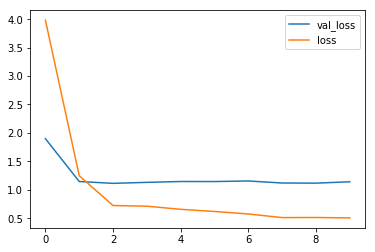

['loss', 'val_loss']


In [55]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss') 
plt.legend()
plt.show()
print(history.history.keys())

In [29]:
emb_vecs = np.zeros((len(x_train_1),5))
for i,x in enumerate(x_train_1):
    x = (x/255).astype(np.float32)
    emb_vecs[i]= embedding_model.predict(np.expand_dims(x,axis=0))

In [30]:
print(emb_vecs)
def distance(emb1, emb2):
    return np.sqrt(np.sum(np.square(emb1- emb2)))

[[0.45521691 0.48659721 0.44169757 0.40796411 0.44098684]
 [0.45523128 0.48657638 0.44161367 0.40796053 0.44108209]
 [0.4555532  0.48673886 0.44147432 0.40796384 0.44070685]
 ...
 [0.45560342 0.48659813 0.44154149 0.40796041 0.44074616]
 [0.45539838 0.48666647 0.44187936 0.40796798 0.44053686]
 [0.45530465 0.48663166 0.44157565 0.40795553 0.44098815]]


In [31]:
from scipy import stats
def k_nearest_neighbor(embedding_values,labels,test_value,k): 
    '''calculates the k nearest neighbor a a given test_value and a particular k'''
    similar=np.zeros(len(embedding_values))
    for i,emb_vec in enumerate(embedding_values):
        similar[i] = distance(test_value,emb_vec)
    arrangement= np.argsort(similar)
    arrangement=arrangement[:k]
    k_nearest=labels[arrangement]
    correct_index_list=stats.mode(k_nearest)
    correct_index=correct_index_list[0].tolist()
    return correct_index[0]

In [50]:
test_image=x_train_1[100]
test_image=embedding_model.predict(np.expand_dims(test_image,axis=0))
correct_index=k_nearest_neighbor(emb_vecs,y_train_1,test_image,5)
print(correct_index)
print(y_train_1[100])

6
5


In [52]:
score=0
count=0
for i,x in enumerate(emb_vecs):
    pred=k_nearest_neighbor(emb_vecs,y_train_1,x,5)
    if (pred==y_train_1[i]):
        score=score+1
    if (count==100):
        break 
    count=count+1
    print(score)

0
1
2
3
3
4
5
5
6
7
8
9
10
11
12
13
13
14
14
15
16
17
18
19
19
20
21
22
22
22
23
24
25
26
26
27
28
29
30
30
31
32
33
34
34
35
36
37
38
39
40
41
42
43
43
44
45
46
47
48
48
49
50
50
50
50
51
52
53
53
53
53
54
55
56
56
57
58
59
59
59
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
73
74
74
75


In [53]:
score=triplet_model.evaluate_generator(triplet_generator(x_test_1,y_test_1,batch_size),steps=100, max_queue_size=1, workers=1, use_multiprocessing=False)
print(score)

1.1581016862392426


In [ ]:
predict=triplet_model.predict_generator(triplet_generator(x_test_1,y_test_1,batch_size),steps=100,workers=1)

test_image=x_train_1[4]
test_image=embedding_model.predict(np.expand_dims(test_image,axis=0))
correct_index=k_nearest_neighbor(emb_vecs,y_train_1,test_image,5)
print(correct_index)
print(y_train_1[3])

In [38]:
logdir="/Users/samriddhakc/Desktop/logdir"
tf.reset_default_graph()
session=tf.Session()
embedding_var=tf.Variable(emb_vecs,name='mnist_embedding')
saver=tf.train.Saver()
session.run(tf.global_variables_initializer())
saver.save(session,os.path.join(logdir,"model.ckpt"))

'/Users/samriddhakc/Desktop/logdir/model.ckpt'

In [39]:
def write_meta_file(savedir, labels):
    with open(savedir+"/metadata.tsv", "w") as metafile:
        string_array = []
        for label in labels:
            string_array.append(str(label)+"\n")
        metafile.writelines(string_array)

In [40]:
write_meta_file(logdir,y_train_1)